# Inverse Kinematics 3D link arm

In [55]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import pinv, norm
from numpy import sin, cos, pi
tau = 2 * pi

In [63]:
def H(axis, vec, theta): # Homogeneous transformation matrix
    if axis == 'X':
        return np.array([[1,          0,           0, vec[0]],
                         [0, cos(theta), -sin(theta), vec[1]],
                         [0, sin(theta),  cos(theta), vec[2]],
                         [0,          0,           0,      1]])
    elif axis == 'Y':
        return np.array([[cos(theta), 0, -sin(theta), vec[0]],
                         [         0, 1,           0, vec[1]],
                         [sin(theta), 0,  cos(theta), vec[2]],
                         [         0, 0,           0,      1]])
    elif axis == 'Z':
        return np.array([[cos(theta), -sin(theta), 0, vec[0]],
                         [sin(theta),  cos(theta), 0, vec[1]],
                         [         0,           0, 1, vec[2]],
                         [         0,           0, 0,      1]])
    else:
        return np.array([[1, 0, 0, vec[0]],
                         [0, 1, 0, vec[0]],
                         [0, 0, 1, vec[0]],
                         [0, 0, 0,      1]])
    
def FK(L, TH): # Forward kinemtics function
    N = len(L)
    T = H('Z', L[0], TH[0])
    V = np.array(T[:3,-1])
    for i in range(1, N-1):
        T = T @ H('Y', L[i], TH[i])
        V = np.c_[V, T[:3,-1]]
    EE = T @ np.array([[1,0,0,1]]).T
    V = np.c_[V, EE[:3, -1]]
    return V

def angleLimit(TH, MinA, MaxA):
    THCOPY = TH.copy()
    for i in range(len(TH)):
        THCOPY[i] = TH[i] % tau
        if THCOPY[i] > pi:
            THCOPY[i] -= tau
        if THCOPY[i] < MinA[i]:
            THCOPY[i] = MinA[i]
        if THCOPY[i] > MaxA[i]:
            THCOPY[i] = MaxA[i]
    return THCOPY

def conv(TH):
    THCOPY = TH.copy()
    for i in range(len(TH)):
        THCOPY[i] = TH[i] % tau
        if THCOPY[i] > pi:
            THCOPY[i] -= tau
    return THCOPY # not in use for this time

def Plot3D(V): # 3D Plot
    n = len(V[0])
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(bottom=0.1, left=0, top=0.9, right=0.95, wspace=0.3, hspace=0.3)
    ax = fig.add_subplot(221, projection='3d', proj_type='ortho')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim([-1, n-1])
    ax.set_ylim([-1, n-1])
    ax.set_zlim([0, n])
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='z', labelsize=6)
    ax.set_xlabel('X', fontsize=8, rotation='horizontal')
    ax.set_ylabel('Y', fontsize=8, rotation='horizontal')
    ax.set_zlabel('Z', fontsize=8, rotation='horizontal')

    ax1 = fig.add_subplot(222)
    ax1.set_title('Top view(X-Y)', fontsize=10)
    ax1.set_xlabel('X', fontsize=8)
    ax1.set_ylabel('Y', fontsize=8, rotation='horizontal')
    ax1.tick_params(axis='x', labelsize=6)
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_aspect('equal')
    ax1.axis([-1,n-1,-1,n-1])
    ax1.grid()

    ax2 = fig.add_subplot(224)
    ax2.set_title('Front view(X-Z)', fontsize=10)
    ax2.set_xlabel('X', fontsize=8)
    ax2.set_ylabel('Z', fontsize=8, rotation='horizontal')
    ax2.tick_params(axis='x', labelsize=6)
    ax2.tick_params(axis='y', labelsize=6)
    ax2.set_aspect('equal')
    ax2.axis([-1,n-1,-1,n-1])
    ax2.grid()

    ax.plot3D(V[0], V[1], V[2])
    ax.plot3D(V[0], V[1], V[2], 'o', ms=4)
    ax1.plot(V[0], V[1])
    ax1.plot(V[0], V[1], 'o', ms=4)
    ax2.plot([-1, n-1], [0, 0], 'k-')
    ax2.plot(V[0], V[2])
    ax2.plot(V[0], V[2], 'o', ms=4)
    
    ax.plot3D([Target[0]],[Target[1]],[Target[2]], 'rx', ms=10)
    ax1.plot([Target[0]],[Target[1]], 'rx', ms=10)
    ax2.plot([Target[0]],[Target[2]], 'rx', ms=10)

def Jacobian(V): # Jacobian matrix
    UX = np.array([1, 0, 0])
    UY = np.array([0,-1, 0])
    UZ = np.array([0, 0, 1])
    J = []
    for i in range(N):
        if i == 0:
            J.append(np.cross(UZ, V[:, -1] - V[:, i]))
        else:
            J.append(np.cross(UY, V[:, -1] - V[:, i]))
    return np.array(J).T

def TargetVec(Target, L): # Target vector correction (if no reach to the target)
    tv = np.array(Target) - np.array(L[1])
    sumL = np.sum(L[2:])
    if norm(tv) > sumL:
        tv = tv * sumL / norm(tv)
        print('Target overwritten:', tv)
    return tv + np.array(L[1])

## Forward Kinematics:

<IPython.core.display.Javascript object>


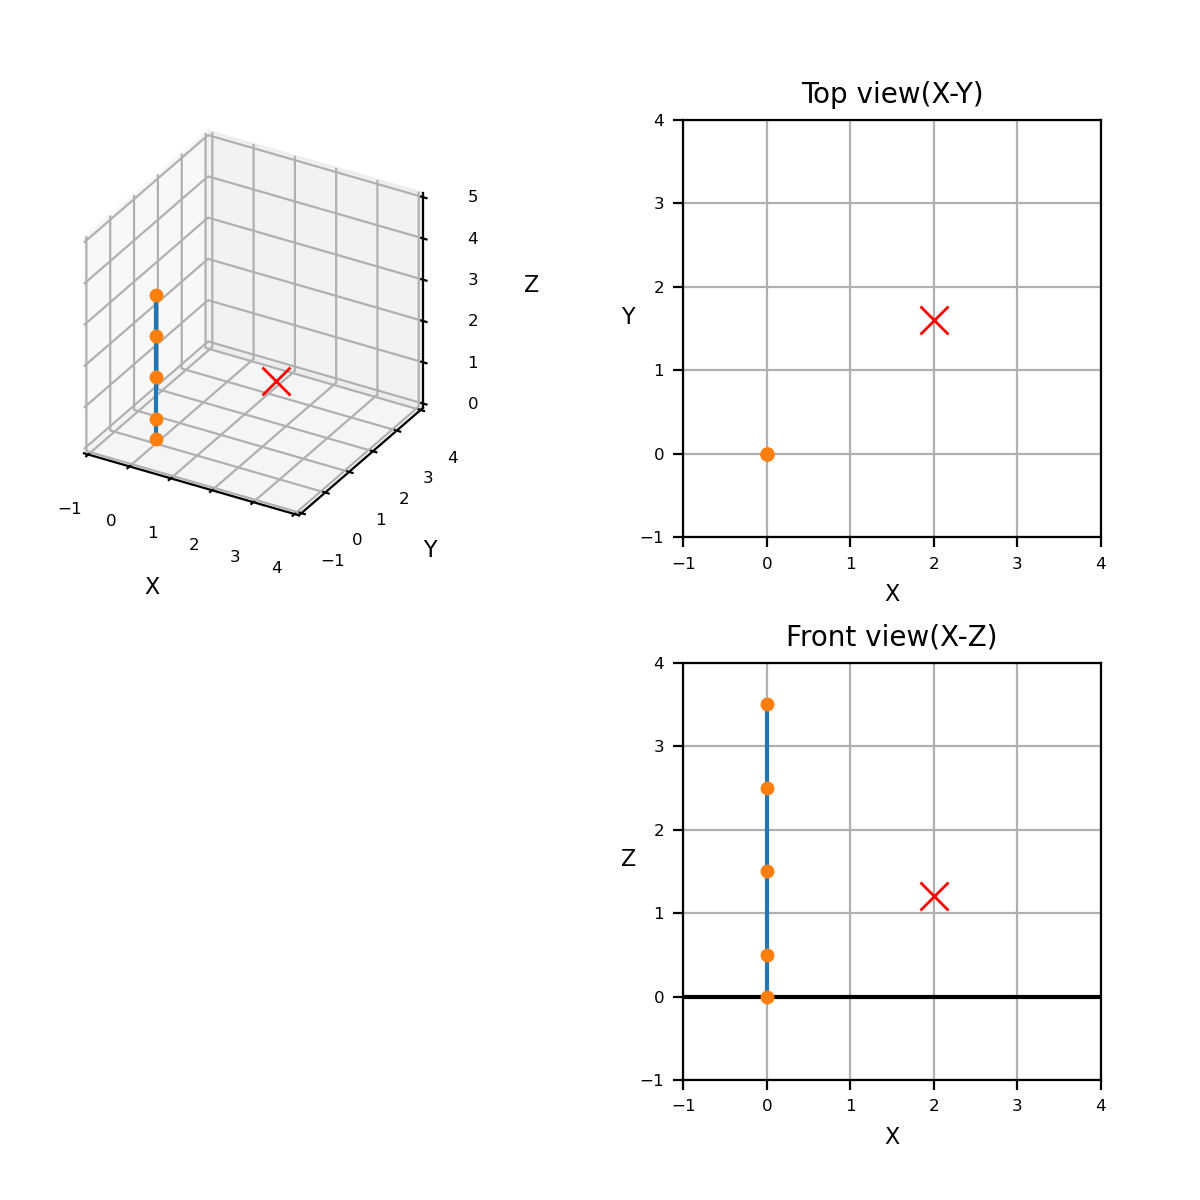

In [64]:
N = 4 # the number of links (N > 2)
TH = np.array([0, pi/2] + [0]*(N-2)) # theta at each joint
MinA = [-pi,  0] + [-pi/2] * (N-2)   # minimum angles for angle limit
MaxA = [ pi, pi] + [ pi/2] * (N-2)   # maximum angles for angle limit
TH = angleLimit(TH, MinA, MaxA)
BaseVec  = [0,0,0]
StandVec = [0,0,0.5]
LinkVec  = [1,0,0]
L = [BaseVec, StandVec] + [LinkVec] * (N-1)

Target = TargetVec([N*0.5, N*0.4, N*0.3], L)
V = FK(L, TH)
Plot3D(V)

## Inverse Kinematics:

Error Norm  : 9.844014996561271e-05
Target      : [2.  1.  1.5]
End-Effector: [1.99995445 1.00000391 1.50008718]
Loop: 453
TH: [26.5656628   0.          1.629683   74.69418108]


<IPython.core.display.Javascript object>


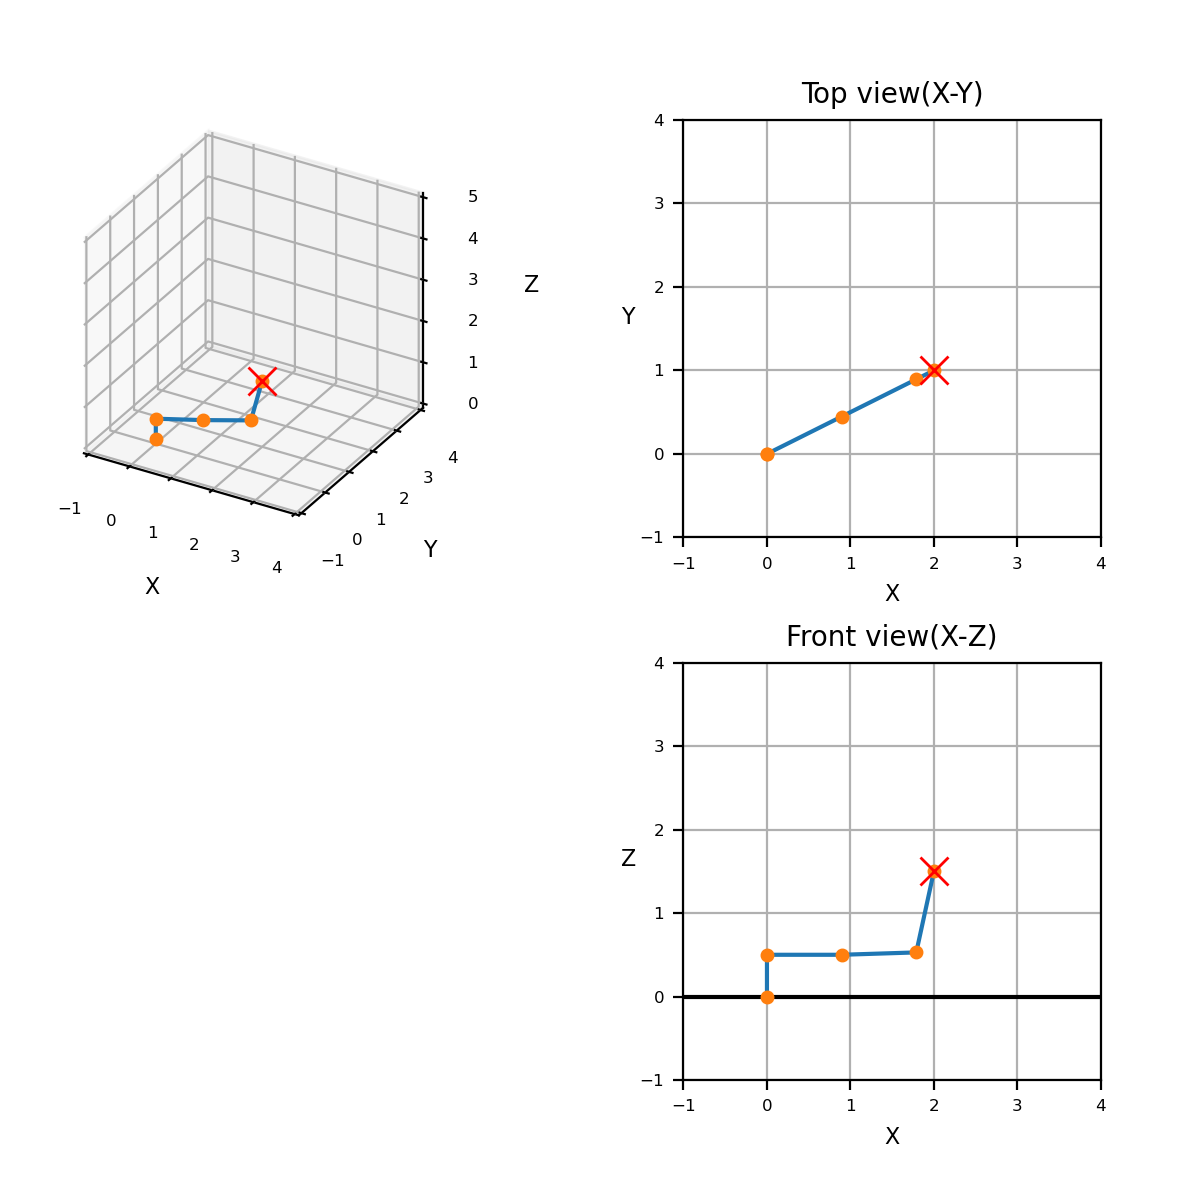

In [65]:
Target = TargetVec([2.0, 1.0, 1.5], L)
MinA = [-pi,  0] + [-pi/2] * (N-2)
MaxA = [ pi, pi] + [ pi/2] * (N-2)
scaler = 0.1
loop = 0

while True:
    global TH
    V = FK(L, TH)
    J = Jacobian(V)
    EE = V[:, -1]
    Error = Target - EE
    if norm(Error) < 1e-4:
        print('Error Norm  :', norm(Error))
        print('Target      :', Target)
        print('End-Effector:', V[:, -1])
        print('Loop:', loop)
        Plot3D(V)
        break
    dTheta = pinv(J) @ Error * scaler
    TH += dTheta
    TH = angleLimit(TH, MinA, MaxA)
    loop += 1
    if loop > 1000:
        print('over 1000 loops')
        break

## IK interactive 3D plot:  

In [88]:
N = 4 # the number of links (N > 2)
TH = np.array([0, pi/2] + [0] * (N-2))
MinA = [-pi,  0] + [-pi/2] * (N-2)
MaxA = [ pi, pi] + [ pi/2] * (N-2)
BaseVec  = [0, 0, 0]
StandVec = [0, 0, 0.5]
LinkVec  = [1, 0, 0]
L = [BaseVec, StandVec] + [LinkVec] * (N-1)
Target = TargetVec([2.0, 1.0, 2.0], L)
V = FK(L, TH)
mx, my, mz = Target
scaler = 0.1

def click(event):
    global TH, mx, my, mz
    if event.inaxes == A10.axes:
        mx = event.xdata
        my = event.ydata
    elif event.inaxes == A20.axes:
        mx = event.xdata
        mz = event.ydata
    else:
        pass
    Target = TargetVec([mx, my, mz], L)
    loop = 0
    while True:
        V = FK(L, TH)
        J = Jacobian(V)
        EE = V[:, -1]
        Error = Target - EE
        dTheta = pinv(J) @ Error * scaler
        TH += dTheta
        TH = angleLimit(TH, MinA, MaxA) 
        # TH = conv(TH)
        if norm(Error) < 1e-4:
            break
        loop += 1
        if loop > 1000:
            break
    
    A00.set_data(V[0], V[1])
    A00.set_3d_properties(V[2])
    A01.set_data(V[0], V[1])
    A01.set_3d_properties(V[2])
    A0X.set_data(mx, my)
    A0X.set_3d_properties(mz)
    
    A10.set_data(V[0], V[1])
    A11.set_data(V[0], V[1])
    A1X.set_data(mx, my)
    
    A20.set_data(V[0], V[2])
    A21.set_data(V[0], V[2])
    A2X.set_data(mx, mz)
    event.canvas.draw()

<IPython.core.display.Javascript object>


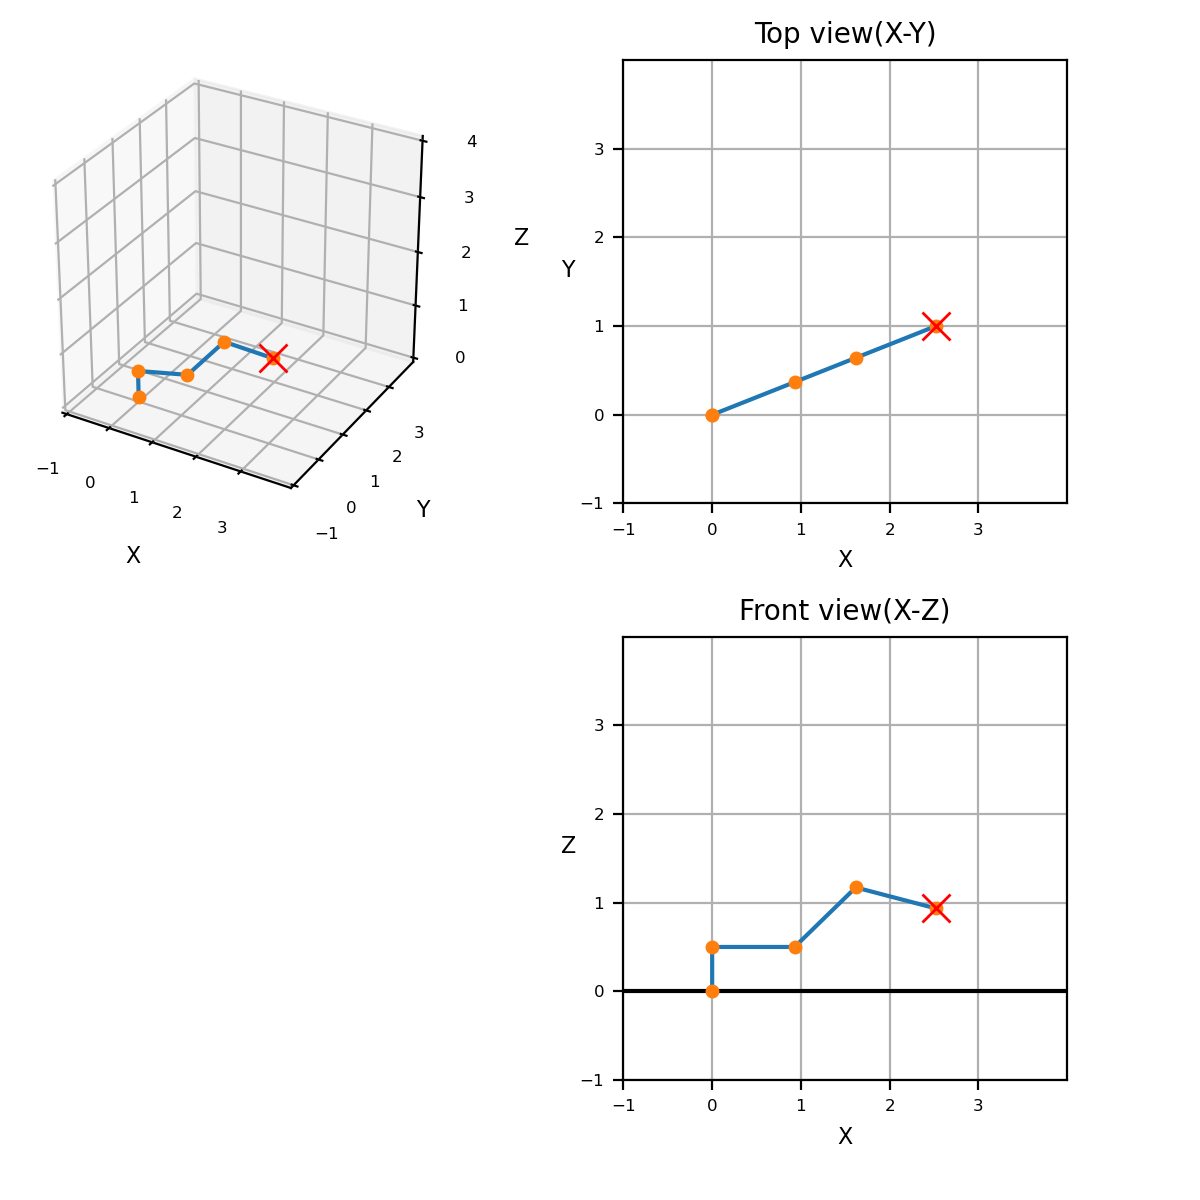

In [89]:
# Interactive 3D Plot: click Top view or Front view to change the target vector 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(221, projection='3d', proj_type='persp')
fig.subplots_adjust(bottom=0.1, left=0, top=0.95, right=0.9, wspace=0.3, hspace=0.3)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1, N])
ax.set_ylim([-1, N])
ax.set_zlim([0, N])
ax.set_xticks([*range(-1, N)])
ax.set_yticks([*range(-1, N)])
ax.set_zticks([*range(N+1)])
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='z', labelsize=6)
ax.set_xlabel('X', fontsize=8, rotation='horizontal')
ax.set_ylabel('Y', fontsize=8, rotation='horizontal')
ax.set_zlabel('Z', fontsize=8, rotation='horizontal')

ax1 = fig.add_subplot(222)
ax1.set_title('Top view(X-Y)', fontsize=10)
ax1.set_xlabel('X', fontsize=8, rotation='horizontal')
ax1.set_ylabel('Y', fontsize=8, rotation='horizontal')
ax1.set_xticks([*range(-1, N)])
ax1.set_yticks([*range(-1, N)])
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.set_aspect('equal')
ax1.axis([-1,N,-1,N])
ax1.grid()

ax2 = fig.add_subplot(224)
ax2.set_title('Front view(X-Z)', fontsize=10)
ax2.set_xlabel('X', fontsize=8, rotation='horizontal')
ax2.set_ylabel('Z', fontsize=8, rotation='horizontal')
ax2.set_xticks([*range(-1, N)])
ax2.set_yticks([*range(-1, N)])
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.set_aspect('equal')
ax2.axis([-1,N,-1,N])
ax2.grid()

A00, = ax.plot(V[0],V[1],V[2]) # 3D view
A01, = ax.plot(V[0],V[1],V[2], 'o', ms=4)
A0X, = ax.plot(mx,my,mz, 'rx', ms=10)

A10, = ax1.plot(V[0],V[1])   # Top view
A11, = ax1.plot(V[0],V[1], 'o', ms=4)
A1X, = ax1.plot(mx,my, 'rx', ms=10)

ax2.plot([-1, N], [0, 0], 'k-') # Front view
A20, = ax2.plot(V[0],V[2])   
A21, = ax2.plot(V[0],V[2], 'o', ms=4)
A2X, = ax2.plot(mx,mz, 'rx', ms=10)


fig.canvas.mpl_connect('button_press_event', click)
plt.show()